In [131]:
import re
import matplotlib.pyplot as plt
#establishing ground truth 

#Find true frequencies 
f = open("./data/descartes.txt", "r")
tf = {}
#create a words array which are the words in the text
gwords = []
for line in f:
    words = line.split(" ")
    for word in words:
        fword = re.sub(r'\W', '', word)
        gwords.append(fword)
        if tf.get(fword) == None:
            tf[fword] = 1
        else:
            tf[fword] = tf.get(fword) + 1
f.close()
#find the top 30 highest frequency words 
sorted_dict = {}
sorted_keys = sorted(tf, reverse= True, key=tf.get) 
sorted_keys = sorted_keys[0:30]
for k in sorted_keys:
    sorted_dict[k] = tf[k]
#form the ground truth 
ground_truth = sorted_dict

print(len(gwords))

23345


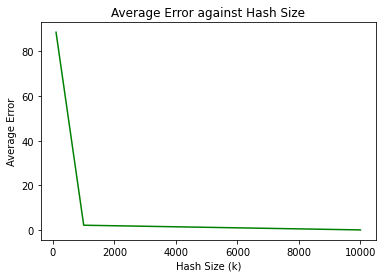

3


In [172]:
import mmh3
import numpy as np 
import random 
import math 

"""
buildCounters: this method creates the kt counters table that store the frequencies in this algo
@ param delta: this is a configurable value
@ param k: this the size of the hash 
@ param stream: this is the massive array of words that we will get
"""
def buildCounters(delta, k, stream, seeds):
    #t hash functions
    t = math.ceil(np.log(1/delta))

    #init kt counters in counters array
    counters = []
    for i in range(0, t):
        counters.append([0]*k)
    
    #deal with the stream -- treat each (i, c) as word with c = 1
    for word in stream: 
        #hash the word into each distinct C using a distinct hash
        for i in range(0, t):
            counters[i][mmh3.hash(word, seeds[i])%k] += 1
    
    return counters
"""
queryWord: this method finds the stored frequency of a word
@ param word: word we want the freq of 
@ param counters: table of values
@ param k: hash size
@ param delta: this is a configurable value
"""
def queryWord(word, counters, k, delta, seeds):
    #go through all t counters, and find the minimum value of associated with the hash of the word
    t = math.ceil(np.log(1/delta))
        
    m = counters[0][mmh3.hash(word, seeds[0])%k]
    for i in range(1, t):
        if counters[i][mmh3.hash(word, seeds[i])%k] < m:
            m = counters[i][mmh3.hash(word, seeds[i])%k]
    return m

def countMin(delta, k, stream):
    
    #geneate t random seeds
    t = math.ceil(np.log(1/delta))
    seeds = []
    for i in range(0,t):
        seeds.append(random.randint(0,k))
        
    #build counters
    counters = buildCounters(delta, k, stream, seeds)
    
    #cumulative error
    cerror = 0
    for word in ground_truth.keys():
        #difference between est and ground truth 
        cerror += abs(ground_truth.get(word) -  queryWord(word, counters, k, delta, seeds))
        
    # return averaged error
    return cerror/len(ground_truth.keys())

def visualizeCountMin():
    ks = [100, 1000, 10000]
    error = []
    for k in ks:
        error.append(countMin(.01, k, gwords))
    plt.plot(ks, error, color = "g")
    plt.title("Count Min: Average Error against Hash Size")
    plt.xlabel("Hash Size (k)")
    plt.ylabel("Average Error")
    plt.show()
    print(len(error))
visualizeCountMin()

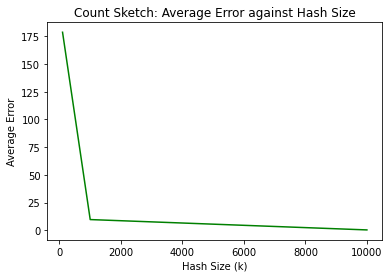

In [173]:
#count-sketch 
"""
csCounters: method that builds the counter 
@ params: pretty self explanatory parameters, note that r1 & r2 are random seeds between 0 & k 
"""
def csCounters(delta, k, stream, r1, r2):
    # counters
    C = [0]*k
    for word in stream:
        C[mmh3.hash(word, r1)%k] = C[mmh3.hash(word, r1)%k] + int((mmh3.hash(word, r2)%2 -.5)*2)
    return C
"""
countSketch: this method finds the average error between the prediction and all words in the ground_truth for a given k
@params: again, pretty self explanatory; note that k will vary
"""
def countSketch(delta, k, stream):
    #random seeds
    r1 = random.randint(0,k)
    r2 = random.randint(0,k)
        
    #build counters
    C = csCounters(delta, k, stream, r1, r2)
    
    #cumulative error
    cerror = 0
    for word in ground_truth.keys():
        #difference between est and ground truth 
        cerror += abs(ground_truth.get(word) - int((mmh3.hash(word, r2)%2 -.5)*2)*C[mmh3.hash(word, r1)%k])
        
    # return averaged error
    return cerror/len(ground_truth.keys())
"""
visualizeCountSketch: this method will visualize the avg. error across different k values
"""
def visualizeCountSketch():
    ks = [100, 1000, 10000]
    error = []
    #determine avg. error for each k 
    for k in ks:
        error.append(countSketch(.01, k, gwords))
    #graphing stuff
    plt.plot(ks, error, color = "g")
    plt.title("Count Sketch: Average Error against Hash Size")
    plt.xlabel("Hash Size (k)")
    plt.ylabel("Average Error")
    plt.show()
    
visualizeCountSketch()

the:1378
365
0.01563503962304562


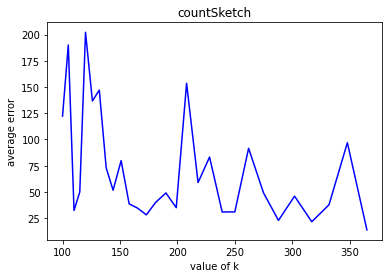

the:1378
426
0.018248018847718997


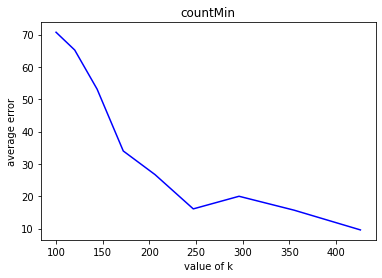

In [171]:
#find highest/lowest freq word, and see what you need to do to k to get average error <= .01freq

"""
findK: this method finds the k for which the average error for the frequency estimate of a particular word is below 
.01*ground_truth. 

@ delta: this is self explanatory 
@ stream: the stream of words
@ index: the index of the word (0) for most frequent (29) for least frequent 
"""
def findK(delta, stream, index, mode):
    word = sorted_keys[index]
    print("%s:%d" % (word, ground_truth.get(word)))
    #num trials 
    trial_num = 10
    #k wil increase
    k = 100
    #track different ks
    karray = [] 
    #track avg. error
    errors = []
    if mode == "countMin":
        while(True):
            cerror = 0
            for i in range(0, trial_num):
                #geneate t random seeds
                t = math.ceil(np.log(1/delta))
                seeds = []
                for i in range(0,t):
                    seeds.append(random.randint(0,k))
                #build counters
                counters = buildCounters(delta,k, stream, seeds)
                #find difference
                cerror += abs(ground_truth.get(word) -  queryWord(word, counters, k, delta, seeds))
            #calculate avg error
            avg_error = cerror/trial_num
            #add to lists
            karray.append(k)
            errors.append(avg_error)
            #check if satisfies condition
            if avg_error <= delta*ground_truth.get(word):
                print(k)
                print(k/len(gwords))
                break
            k += int(k/5)
    elif mode == "countSketch":
         while(True):
            cerror = 0
            for i in range(0, trial_num):
                #random seeds
                r1 = random.randint(0,k)
                r2 = random.randint(0,k)
                #build counter
                C = csCounters(delta,k, stream, r1, r2)
                #find difference
                cerror += abs(ground_truth.get(word) - int((mmh3.hash(word, r2)%2 -.5)*2)*C[mmh3.hash(word, r1)%k])
            
            #calculate avg error
            avg_error = cerror/trial_num
            #add to lists
            karray.append(k)
            errors.append(avg_error)
            #check if satisfies condition
            if avg_error <= delta*ground_truth.get(word):
                print(k)
                print(k/len(gwords))
                break
            k += int(k/20)
    plt.plot(karray, errors, color = "b")
    plt.title(mode)
    plt.xlabel("value of k")
    plt.ylabel("average error")
    plt.show()

"""
***

To use, findK takes as arguments delta = .01, gwords which is the array version of the text (short for ground truth words)
0-29 which correspond to the first 30 words in the grount truth (i.e. 0 for the most frequent, 30 for the least),
and "countMin" or "countSketch"

***
"""
findK(.01, gwords, 0, "countSketch")
findK(.01, gwords, 0, "countMin")


In [ ]:
#bonus part of problem 
#.... nvm too hard